In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import tensorflow as tf
import keras_lmu

2023-03-28 08:40:38.882978: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 08:40:39.588740: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-03-28 08:40:39.588788: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-03-28 08:40:39.588794: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
sequentialMNIST = pickle.load(open('Data/sequentialMNIST.pickle', 'rb'))
permutedMNIST = pickle.load(open('Data/permutedMNIST.pickle', 'rb'))

train_sequential_X = sequentialMNIST['train']['images']
train_sequential_y = sequentialMNIST['train']['labels']
train_permuted_X = permutedMNIST['train']['images']
train_permuted_y = permutedMNIST['train']['labels']

In [3]:
# Stratified 80-20 split into train and validation sets
from sklearn.model_selection import train_test_split

train_sequential_X, val_sequential_X, train_sequential_y, val_sequential_y = train_test_split(train_sequential_X, train_sequential_y, test_size=0.2, stratify=train_sequential_y, random_state=42)
train_permuted_X, val_permuted_X, train_permuted_y, val_permuted_y = train_test_split(train_permuted_X, train_permuted_y, test_size=0.2, stratify=train_permuted_y, random_state=42)

# Check Shapes
print('Sequential MNIST')
print('Train X Shape: ', train_sequential_X.shape)
print('Train y Shape: ', train_sequential_y.shape)
print('Validation X Shape: ', val_sequential_X.shape)
print('Validation y Shape: ', val_sequential_y.shape)

print('Permuted MNIST')
print('Train X Shape: ', train_permuted_X.shape)
print('Train y Shape: ', train_permuted_y.shape)
print('Validation X Shape: ', val_permuted_X.shape)
print('Validation y Shape: ', val_permuted_y.shape)

Sequential MNIST
Train X Shape:  (48000, 784, 1)
Train y Shape:  (48000,)
Validation X Shape:  (12000, 784, 1)
Validation y Shape:  (12000,)
Permuted MNIST
Train X Shape:  (48000, 784, 1)
Train y Shape:  (48000,)
Validation X Shape:  (12000, 784, 1)
Validation y Shape:  (12000,)


In [4]:
# loop and check labels are same for each split

for i in range(len(train_sequential_y)):
    assert np.array_equal(train_sequential_y[i], train_permuted_y[i])

for i in range(len(val_sequential_y)):
    assert np.array_equal(val_sequential_y[i], val_permuted_y[i])

### 1. Visualize 3 Random Images

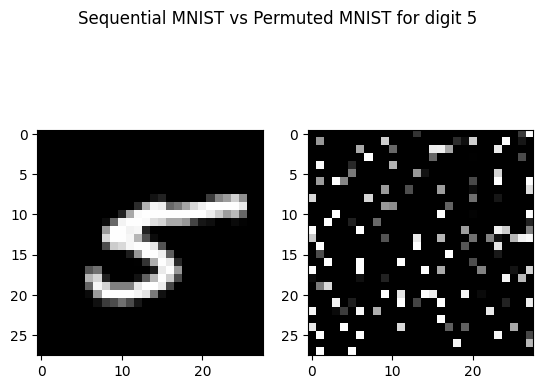

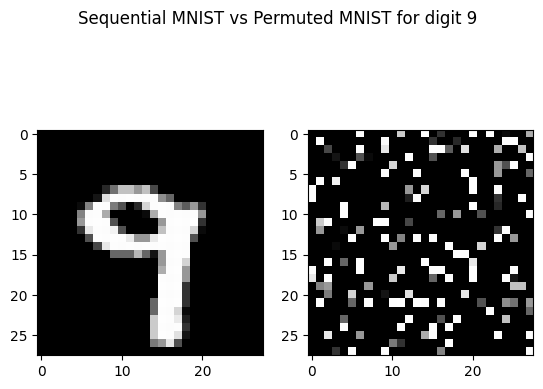

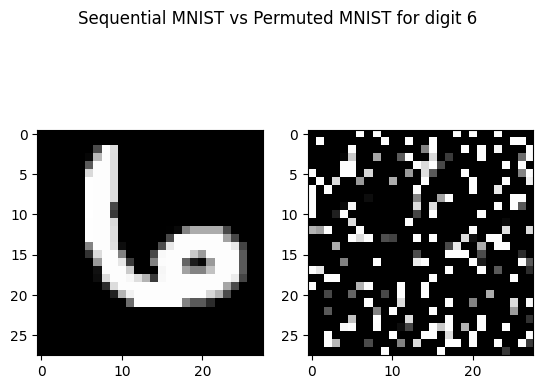

In [5]:
for i in range(3):
    # Set Seed
    np.random.seed(i)
    # Choose a random image
    random_index = np.random.randint(0, len(train_sequential_X))
    # Plot the image at the random index from both datasets
    plt.subplot(1, 2, 1)
    plt.imshow(train_sequential_X[random_index].reshape(28,28), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(train_permuted_X[random_index].reshape(28,28), cmap='gray')
    plt.suptitle('Sequential MNIST vs Permuted MNIST for digit {}'.format(train_sequential_y[random_index]))
    plt.show()

### 2. RNN Based Architecture

In [6]:
n_pixels = train_sequential_X.shape[1]

lmu_layer = tf.keras.layers.RNN(
    keras_lmu.LMUCell(
        memory_d=1,
        order=256,
        theta=n_pixels,
        hidden_cell=tf.keras.layers.SimpleRNNCell(212),
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=True,
        kernel_initializer="ones",
    )
)

# TensorFlow layer definition
inputs = tf.keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(10)(lmus)

# TensorFlow model definition
model_smnist = tf.keras.Model(inputs=inputs, outputs=outputs)
model_smnist.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model_smnist.summary()

2023-03-28 08:40:52.104469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 08:40:52.105150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 08:40:52.106283: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 08:40:52.110848: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-28 08:40:52.111525: I tensorflow/compiler/xla/stream_executo

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 784, 1)]          0         
                                                                 
 rnn (RNN)                   (None, 212)               99641     
                                                                 
 dense (Dense)               (None, 10)                2130      
                                                                 
Total params: 101,771
Trainable params: 101,771
Non-trainable params: 0
_________________________________________________________________


In [11]:
do_training = True
batch_size = 100
epochs = 20

saved_weights_fname_smnist = "Saves/sMNIST-weights.hdf5"

In [8]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_weights_fname_smnist, monitor="val_loss", verbose=1, save_best_only=True
    ),
]

if do_training:
    result = model_smnist.fit(
        train_sequential_X,
        train_sequential_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_sequential_X, val_sequential_y),
        callbacks=callbacks,
    )

Epoch 1/20


2023-03-28 07:11:39.149355: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x6c7da9b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 07:11:39.149381: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): RTX A6000, Compute Capability 8.6
2023-03-28 07:11:39.149385: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): RTX A6000, Compute Capability 8.6
2023-03-28 07:11:39.149389: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): RTX A5000, Compute Capability 8.6
2023-03-28 07:11:39.153498: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-28 07:11:39.211344: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 07:11:39.251322: I tensorflow/compiler/jit/xla_comp

480/480 [==============================] - ETA: 0s - loss: 0.5114 - accuracy: 0.8444
Epoch 1: val_loss improved from inf to 0.31322, saving model to Saves/sMNIST-weights.hdf5
480/480 [==============================] - 180s 372ms/step - loss: 0.5114 - accuracy: 0.8444 - val_loss: 0.3132 - val_accuracy: 0.9067
Epoch 2/20
480/480 [==============================] - ETA: 0s - loss: 0.2704 - accuracy: 0.9206
Epoch 2: val_loss improved from 0.31322 to 0.24600, saving model to Saves/sMNIST-weights.hdf5
480/480 [==============================] - 178s 372ms/step - loss: 0.2704 - accuracy: 0.9206 - val_loss: 0.2460 - val_accuracy: 0.9271
Epoch 3/20
480/480 [==============================] - ETA: 0s - loss: 0.2073 - accuracy: 0.9382
Epoch 3: val_loss improved from 0.24600 to 0.19174, saving model to Saves/sMNIST-weights.hdf5
480/480 [==============================] - 180s 375ms/step - loss: 0.2073 - accuracy: 0.9382 - val_loss: 0.1917 - val_accuracy: 0.9426
Epoch 4/20
480/480 [====================

In [9]:
with open('Saves/sMNIST', "wb")as fp:
    pickle.dump(result, fp)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......input_layer
.........vars
......rnn
.........cell
............hidden_cell
...............vars
..................0
..................1
..................2
............vars
...............0
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-28 08:12:00         2802
metadata.json                                  2023-03-28 08:12:00           64
variables.h5                                   2023-03-28 08:12:00      1250360


In [29]:
with open('Saves/sMNIST', "rb" ) as f:
    result = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-28 08:12:00         2802
metadata.json                                  2023-03-28 08:12:00           64
variables.h5                                   2023-03-28 08:12:00      1250360
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......input_layer
.........vars
......rnn
.........cell
............hidden_cell
...............vars
..................0
..................1
..................2
............vars
...............0
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


Maximum validation accuracy: 97.31%


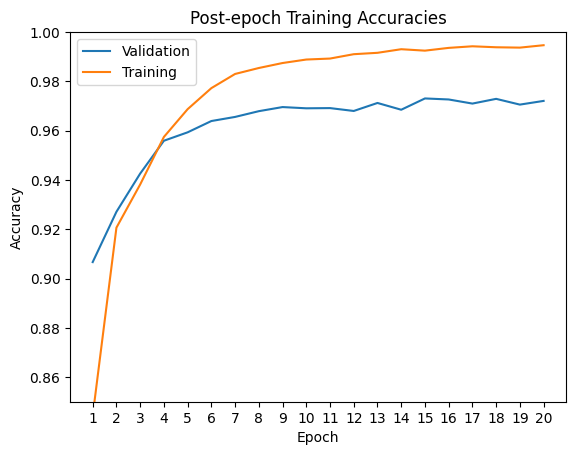

In [30]:
plt.figure()
plt.plot(result.history["val_accuracy"], label="Validation")
plt.plot(result.history["accuracy"], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Post-epoch Training Accuracies")
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
plt.savefig("Saves/sMNIST-training-accuracy.png")

val_loss_min = np.argmin(result.history["val_loss"])
print(
    f"Maximum validation accuracy: "
    f"{round(result.history['val_accuracy'][val_loss_min] * 100, 2):.2f}%"
)

Minimum validation loss:  0.10


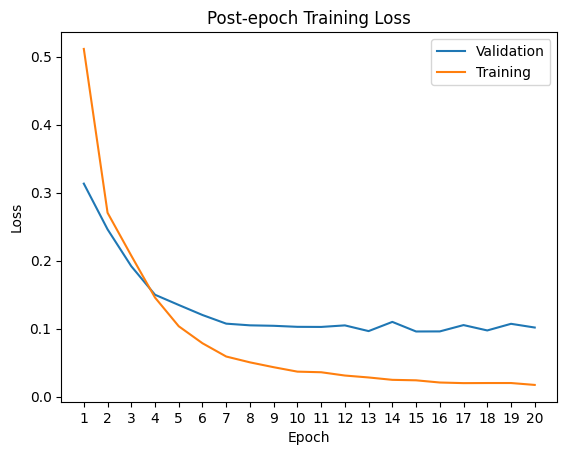

In [31]:
plt.figure()
plt.plot(result.history["val_loss"], label="Validation")
plt.plot(result.history["loss"], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Post-epoch Training Loss")
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
# plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
plt.savefig("Saves/sMNIST-training-loss.png")

val_loss_min = np.argmin(result.history["val_loss"])
print(
    f"Minimum validation loss: ",
    f"{round(result.history['val_loss'][val_loss_min], 2):.2f}"
)

In [14]:
model_smnist.load_weights(saved_weights_fname_smnist)

In [17]:
from sklearn.metrics import classification_report
# get class wise F1 score
y_pred = model_smnist.predict(val_sequential_X)
y_pred = np.argmax(y_pred, axis=1)
clf_report = classification_report(val_sequential_y, y_pred, output_dict=True)
df = pd.DataFrame(clf_report).transpose()
df.to_csv('Saves/sMNIST-classification_report.csv')
print(df)

375/375 [==============================] - 42s 112ms/step
              precision    recall  f1-score       support
0              0.985762  0.993249  0.989491   1185.000000
1              0.987361  0.985163  0.986261   1348.000000
2              0.980392  0.964765  0.972516   1192.000000
3              0.966366  0.960848  0.963599   1226.000000
4              0.967660  0.973459  0.970551   1168.000000
5              0.971349  0.969557  0.970452   1084.000000
6              0.983885  0.979730  0.981803   1184.000000
7              0.974461  0.974461  0.974461   1253.000000
8              0.947368  0.969231  0.958175   1170.000000
9              0.964497  0.958824  0.961652   1190.000000
accuracy       0.973083  0.973083  0.973083      0.973083
macro avg      0.972910  0.972929  0.972896  12000.000000
weighted avg   0.973145  0.973083  0.973091  12000.000000


In [19]:
n_pixels = train_sequential_X.shape[1]

lmu_layer = tf.keras.layers.RNN(
    keras_lmu.LMUCell(
        memory_d=1,
        order=256,
        theta=n_pixels,
        hidden_cell=tf.keras.layers.SimpleRNNCell(212),
        hidden_to_memory=False,
        memory_to_memory=False,
        input_to_hidden=True,
        kernel_initializer="ones",
    )
)

# TensorFlow layer definition
inputs = tf.keras.Input((n_pixels, 1))
lmus = lmu_layer(inputs)
outputs = tf.keras.layers.Dense(10)(lmus)

# TensorFlow model definition
model_pmnist = tf.keras.Model(inputs=inputs, outputs=outputs)
model_pmnist.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer="adam",
    metrics=["accuracy"],
)
model_pmnist.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 784, 1)]          0         
                                                                 
 rnn_1 (RNN)                 (None, 212)               99641     
                                                                 
 dense_1 (Dense)             (None, 10)                2130      
                                                                 
Total params: 101,771
Trainable params: 101,771
Non-trainable params: 0
_________________________________________________________________


In [20]:
do_training = True
batch_size = 100
epochs = 20

In [21]:
saved_weights_fname_pmnist = "Saves/pMNIST-weights.hdf5"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_weights_fname_pmnist, monitor="val_loss", verbose=1, save_best_only=True
    ),
]

if do_training:
    result = model_pmnist.fit(
        train_permuted_X,
        train_permuted_y,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(val_permuted_X, val_permuted_y),
        callbacks=callbacks,
    )

Epoch 1/20


2023-03-28 08:45:47.669721: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x587d4160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-28 08:45:47.669753: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): RTX A6000, Compute Capability 8.6
2023-03-28 08:45:47.669758: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): RTX A6000, Compute Capability 8.6
2023-03-28 08:45:47.669762: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (2): RTX A5000, Compute Capability 8.6
2023-03-28 08:45:47.673934: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-03-28 08:45:47.739255: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-28 08:45:47.786241: I tensorflow/compiler/jit/xla_comp

480/480 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.8378
Epoch 1: val_loss improved from inf to 0.33875, saving model to Saves/pMNIST-weights.hdf5
480/480 [==============================] - 181s 373ms/step - loss: 0.5286 - accuracy: 0.8378 - val_loss: 0.3387 - val_accuracy: 0.9015
Epoch 2/20
480/480 [==============================] - ETA: 0s - loss: 0.2944 - accuracy: 0.9118
Epoch 2: val_loss improved from 0.33875 to 0.27697, saving model to Saves/pMNIST-weights.hdf5
480/480 [==============================] - 183s 382ms/step - loss: 0.2944 - accuracy: 0.9118 - val_loss: 0.2770 - val_accuracy: 0.9183
Epoch 3/20
480/480 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.9262
Epoch 3: val_loss improved from 0.27697 to 0.24392, saving model to Saves/pMNIST-weights.hdf5
480/480 [==============================] - 180s 374ms/step - loss: 0.2495 - accuracy: 0.9262 - val_loss: 0.2439 - val_accuracy: 0.9272
Epoch 4/20
480/480 [====================

In [22]:
with open('Saves/pMNIST', "wb")as fp:
    pickle.dump(result, fp)

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers
......dense
.........vars
............0
............1
......input_layer
.........vars
......rnn
.........cell
............hidden_cell
...............vars
..................0
..................1
..................2
............vars
...............0
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-03-28 09:47:55         2820
metadata.json                                  2023-03-28 09:47:55           64
variables.h5                                   2023-03-28 09:47:55      1250360


In [23]:
with open('Saves/pMNIST', "rb" ) as f:
    result = pickle.load(f)

Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-03-28 09:47:54         2820
metadata.json                                  2023-03-28 09:47:54           64
variables.h5                                   2023-03-28 09:47:54      1250360
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......input_layer
.........vars
......rnn
.........cell
............hidden_cell
...............vars
..................0
..................1
..................2
............vars
...............0
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars


Maximum validation accuracy: 95.28%


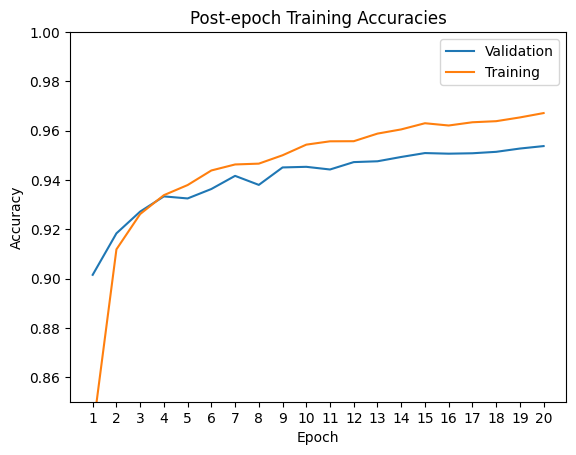

In [24]:
plt.figure()
plt.plot(result.history["val_accuracy"], label="Validation")
plt.plot(result.history["accuracy"], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Post-epoch Training Accuracies")
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
plt.savefig("Saves/pMNIST-training-accuracy.png")

val_loss_min = np.argmin(result.history["val_loss"])
print(
    f"Maximum validation accuracy: "
    f"{round(result.history['val_accuracy'][val_loss_min] * 100, 2):.2f}%"
)

Minimum validation loss: 0.15


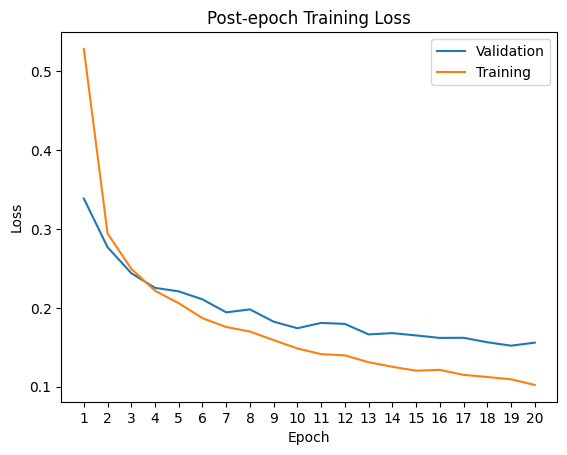

In [28]:
plt.figure()
plt.plot(result.history["val_loss"], label="Validation")
plt.plot(result.history["loss"], label="Training")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Post-epoch Training Loss")
plt.xticks(np.arange(epochs), np.arange(1, epochs + 1))
# plt.ylim((0.85, 1.0))  # Restrict range of y axis to (0.85, 1) for readability
plt.savefig("Saves/pMNIST-training-loss.png")

val_loss_min = np.argmin(result.history["val_loss"])
print(
    f"Minimum validation loss: "
    f"{round(result.history['val_loss'][val_loss_min], 2):.2f}"
)

In [26]:
model_pmnist.load_weights(saved_weights_fname_pmnist)

In [27]:
from sklearn.metrics import classification_report
# get class wise F1 score
y_pred = model_pmnist.predict(val_sequential_X)
y_pred = np.argmax(y_pred, axis=1)
clf_report = classification_report(val_sequential_y, y_pred, output_dict=True)
df = pd.DataFrame(clf_report).transpose()
df.to_csv('Saves/pMNIST-classification_report.csv')
print(df)

375/375 [==============================] - 39s 105ms/step
              precision    recall  f1-score    support
0              0.001767  0.001688  0.001726   1185.000
1              0.002950  0.001484  0.001974   1348.000
2              0.122089  0.272651  0.168656   1192.000
3              0.069776  0.157423  0.096693   1226.000
4              0.123529  0.035959  0.055703   1168.000
5              0.039648  0.066421  0.049655   1084.000
6              0.416438  0.385135  0.400176   1184.000
7              0.017442  0.004789  0.007514   1253.000
8              0.202899  0.011966  0.022599   1170.000
9              0.058288  0.053782  0.055944   1190.000
accuracy       0.098000  0.098000  0.098000      0.098
macro avg      0.105482  0.099130  0.086064  12000.000
weighted avg   0.103840  0.098000  0.084951  12000.000
